In [11]:
import cv2
from all_steps import match_labels_across_images, define_box_around_label
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

In [2]:
from alice.config import PROCESSING_INPUT_DIR
from alice.predict import predict_masks
paths = [PROCESSING_INPUT_DIR / f'011245996_additional_{i}.jpeg' for i in range(1,5)]

In [3]:
all_images = [cv2.imread(str(image_path)) for image_path in paths]

In [4]:
def segment_labels_from_image_path(image_path):
    # Input: image
    # Output: masks (np.array)
    outputs = predict_masks(image_path)
    label_masks = outputs["instances"].to("cpu").pred_masks.numpy()
    return label_masks, cv2.imread(str(image_path))

all_original_masks = []

for image_path in paths:
    label_masks = segment_labels_from_image_path(image_path)
    all_original_masks.append(label_masks)

/Users/ben/Projects/NaturalHistoryMuseum/ALICE/ALICE/.venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
all_masks = match_labels_across_images(all_original_masks)

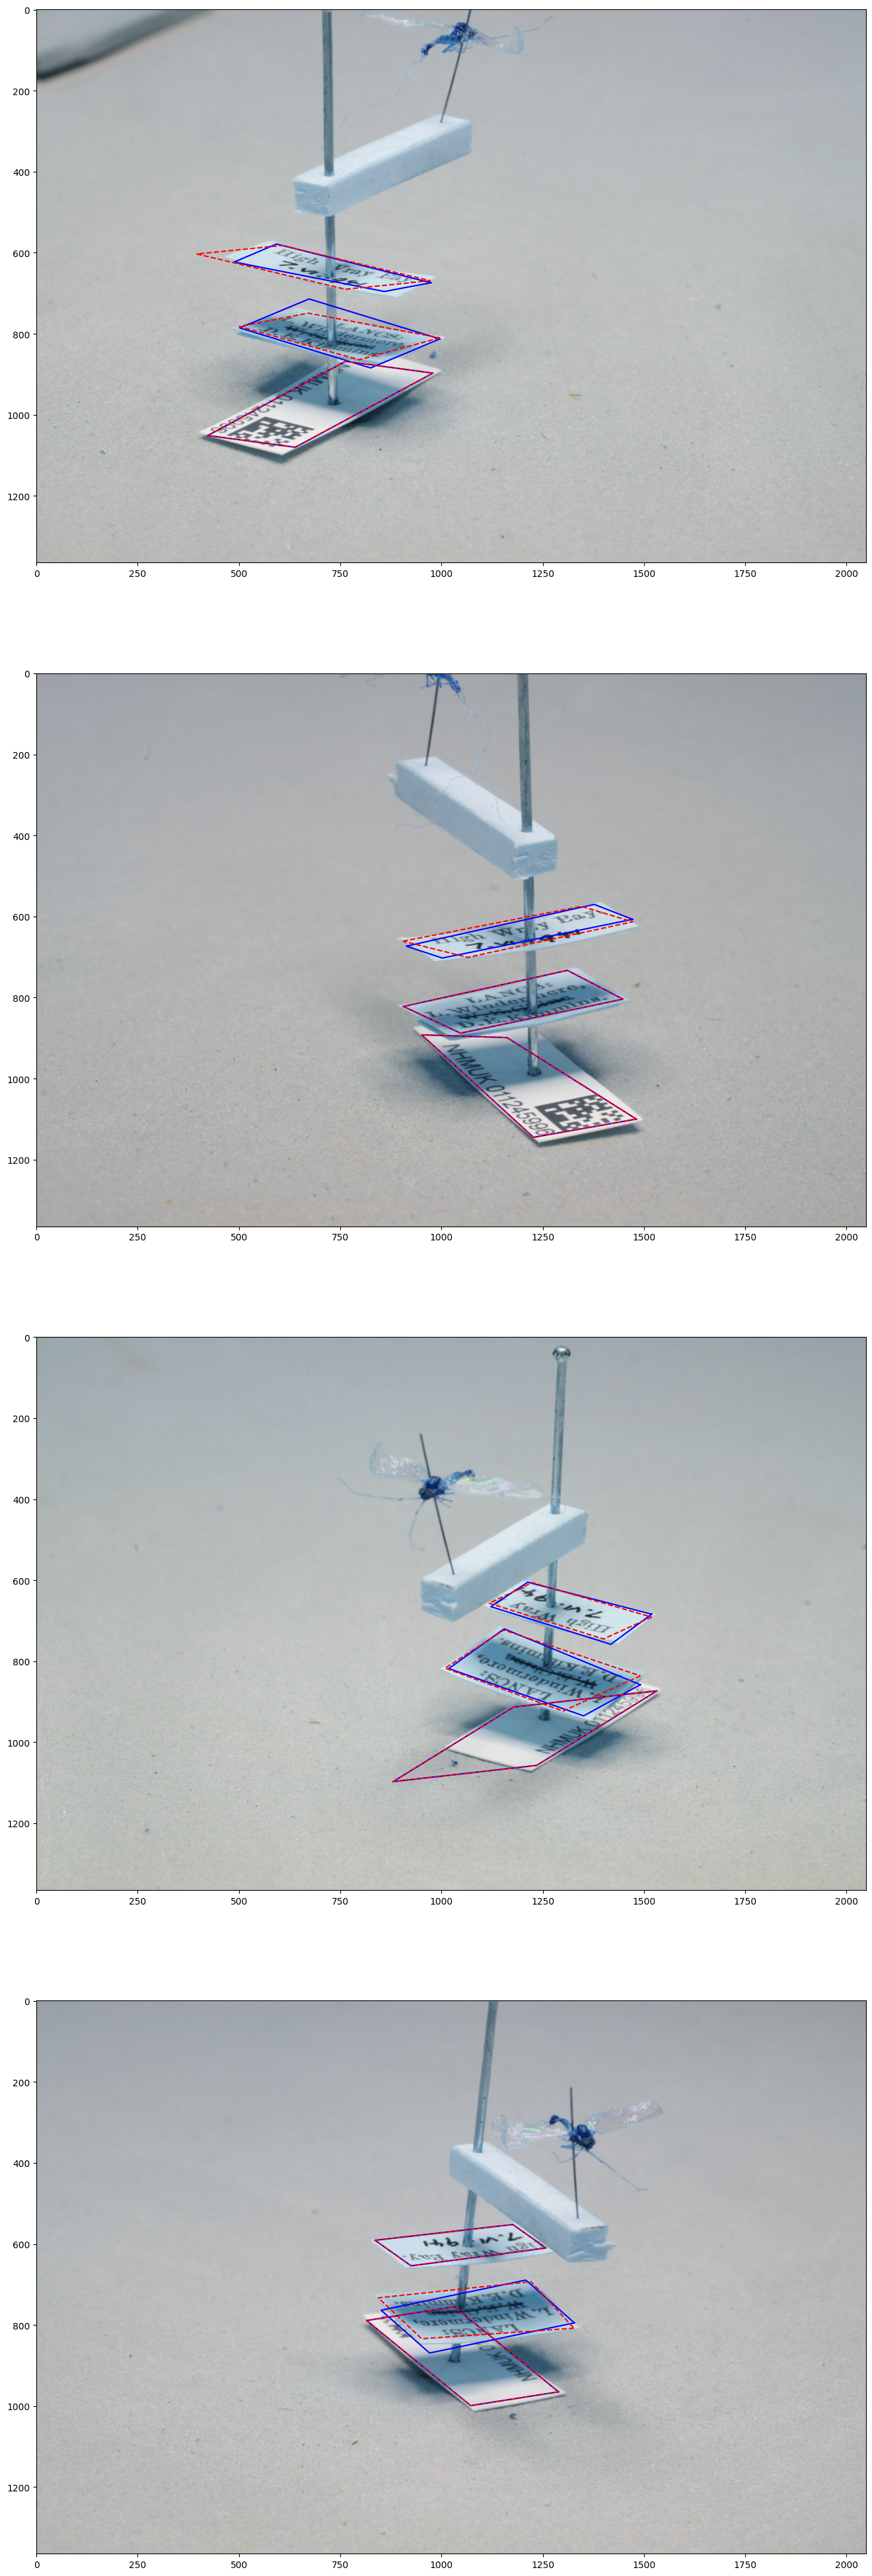

In [6]:
fig,ax = plt.subplots(4,1,figsize=(50,50))
total_masks = np.shape(all_masks)[1]
for i,im in enumerate(all_images):
  ax[i].imshow(im)

  for ind in range(total_masks):
    # Standard Method:
    corner_results1 = define_box_around_label(all_masks[i][ind], im,corner_finding_method=0)
    X1,Y1 = corner_results1[0],corner_results1[1]
    X1.append(X1[0]) # Comment out if don't you want a full box to be plotted.
    Y1.append(Y1[0])
    # # Backup Method:
    corner_results2 = define_box_around_label(all_masks[i][ind], im,corner_finding_method=1)
    X2,Y2 = corner_results2[0],corner_results2[1]
    X2.append(X2[0])
    Y2.append(Y2[0])

    ax[i].plot(X1,Y1,'-b',X2,Y2,'--r')

In [7]:
corner_results2

([1289, 1072, 815, 1032, 1289],
 [965, 999, 789, 755, 965],
 {(0.0, 1.0): 219.647,
  (0.0, 2.0): 505.62,
  (0.0, 3.0): 446.972,
  (1.0, 2.0): 331.887,
  (1.0, 3.0): 286.693,
  (2.0, 3.0): 64.031},
 [[2, 3], [0, 1]],
 [[1, 2], [0, 3]])

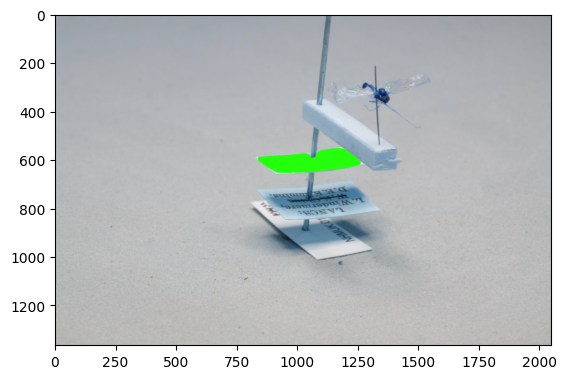

[[1279.1000000000001, 610.6999999999999], [1188.9, 546.9], [814.9, 589.8], [912.8000000000001, 659.1]]
[[0.0, 0.0], [0.0, 119.94510000000001], [376.4519, 119.94510000000001], [376.4519, 0.0]]


In [34]:
def perspective_transform(
    corners_x_updated,
    corners_y_updated,
    img_orig,
    dists_dict,
    short_inds,
    long_inds,
    box_epsilon=1.1,
    fixed_dim=False,
    dimension=(0, 0),
    return_box=False,
    corner_index_method=1,
):
    # Aim: apply a perspective transformation to warp the label into a 2d viewpoint.

    # Input: corners / dictionary of distances between corners.
    # Output: segmented image of warped label.

    mx_long = max(
        [
            dists_dict[(long_inds[0][0], long_inds[0][1])],
            dists_dict[(long_inds[1][0], long_inds[1][1])],
        ]
    )
    mx_short = max(
        [
            dists_dict[(short_inds[0][0], short_inds[0][1])],
            dists_dict[(short_inds[1][0], short_inds[1][1])],
        ]
    )

    # STEP 2: Create desired box.
    #############################

    box_x = [0, 0, mx_long, mx_long, 0]
    box_y = [0, mx_short, mx_short, 0, 0]

    # STEP 3: Match corners.
    ########################

    # Match corners of desired box with current box:
    corner_inds = {}

    if corner_index_method == 0:
        u, v = [short_inds[i][0] for i in range(0, 2)]
        p = np.argmin([corners_x_updated[u], corners_x_updated[v]])
        u, v = short_inds[p]

        i, j = np.argsort([corners_y_updated[u], corners_y_updated[v]])
        k = [u, v][i]
        corner_inds["bot_left"] = [corners_x_updated[k], corners_y_updated[k]]
        k = [u, v][j]
        corner_inds["top_left"] = [corners_x_updated[k], corners_y_updated[k]]

        p = (p + 1) % 2
        u, v = short_inds[p]

        i, j = np.argsort([corners_y_updated[u], corners_y_updated[v]])
        k = [u, v][i]
        corner_inds["bot_right"] = [corners_x_updated[k], corners_y_updated[k]]
        k = [u, v][j]
        corner_inds["top_right"] = [corners_x_updated[k], corners_y_updated[k]]
    elif corner_index_method == 1:
        b = np.argsort(
            [
                np.average(np.array(corners_y_updated)[short_inds[i]])
                for i in range(0, 2)
            ]
        )
        c = np.argsort(np.array(corners_x_updated)[short_inds[b[0]]])
        top_left = short_inds[b[0]][c[0]]
        bot_left = short_inds[b[0]][c[1]]
        d = np.argsort(np.array(corners_x_updated)[short_inds[b[1]]])
        top_right = short_inds[b[1]][d[0]]
        bot_right = short_inds[b[1]][d[1]]

        corner_inds["top_left"] = [
            corners_x_updated[top_left],
            corners_y_updated[top_left],
        ]
        corner_inds["bot_left"] = [
            corners_x_updated[bot_left],
            corners_y_updated[bot_left],
        ]
        corner_inds["top_right"] = [
            corners_x_updated[top_right],
            corners_y_updated[top_right],
        ]
        corner_inds["bot_right"] = [
            corners_x_updated[bot_right],
            corners_y_updated[bot_right],
        ]

    order = ["bot_left", "top_left", "top_right", "bot_right"]
    pts1 = []
    pts2 = []

    mx = (max(corners_x_updated) + min(corners_x_updated)) / 2
    my = (max(corners_y_updated) + min(corners_y_updated)) / 2

    v = box_epsilon - 1
    a, b = np.array([mx, my]) * v

    for i in range(0, 4):
        pts1.append(
            [
                (corner_inds[order[i]][0] * box_epsilon) - a,
                (corner_inds[order[i]][1] * box_epsilon) - b,
            ]
        )
        pts2.append([box_x[i] * box_epsilon, box_y[i] * box_epsilon])

    print(pts1)
    print(pts2)

    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)

    img_filled = deepcopy(img_orig)
    a3 = np.array([np.array([pts1[:, 0], pts1[:, 1]]).T], dtype=np.int32)

    # Fill background (exterior of label contour) in one colour (fill_col)
    fill_col = [255, 0, 0]
    img_filled = cv2.fillPoly(img_filled, a3, fill_col)

    img_s = deepcopy(img_orig)
    img_s[np.where(img_filled != [255, 0, 0])[:2]] = 0

    M = cv2.getPerspectiveTransform(pts1, pts2)
    # Slightly adjust boundary:

    if fixed_dim == False:
        dim = (int(max(pts2[:, 0])), int(max(pts2[:, 1])))
    else:
        dim = dimension

    img_warped = cv2.warpPerspective(img_s, M, dim)

    if return_box == True:
        return img_warped, img_s, pts1, pts2
    else:
        return img_warped, img_s

MINIMUM_LABEL_SIZE = 20

def warp_label(
    corner_results, image, original_mask, minimum_label_size=MINIMUM_LABEL_SIZE
):
    # Input: Corners of labels (results from define_box_around_label), original image / mask.
    # Output: Four warped labels (after perspective transformation).

    (
        corners_x_updated,
        corners_y_updated,
        distance_between_corners,
        short_side_index,
        long_side_index,
    ) = corner_results

    warped_label, _ = perspective_transform(
        corners_x_updated,
        corners_y_updated,
        image,
        distance_between_corners,
        short_side_index,
        long_side_index,
    )

    if any(np.array(np.shape(warped_label)[:2]) < minimum_label_size):
        corner_results = define_box_around_label(
            original_mask, image, corner_finding_method=1, combine_label_masks=False
        )
        (
            corners_x_updated,
            corners_y_updated,
            distance_between_corners,
            short_side_index,
            long_side_index,
        ) = corner_results
        warped_label, _ = perspective_transform(
            corners_x_updated,
            corners_y_updated,
            image,
            distance_between_corners,
            short_side_index,
            long_side_index,
        )

    return warped_label

i = 3
image = deepcopy(all_images[i])
label_mask = all_masks[i][0]

image[label_mask==True] = (36,255,12)
plt.imshow(image)
plt.show()  

corner_results2 = define_box_around_label(label_mask, image,corner_finding_method=1)

warped_label = warp_label(corner_results2, image, label_mask)

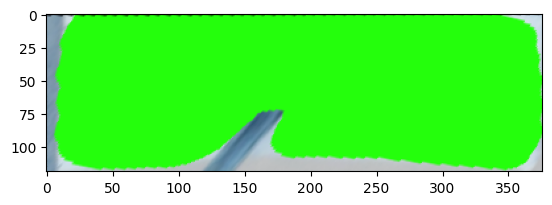

In [33]:
plt.imshow(warped_label)
plt.show()  